In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from geopy.distance import geodesic
import joblib

In [4]:
credit_card_data = pd.read_csv('dataset.csv')
credit_card_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [5]:
credit_card_data['trans_date_trans_time'] = pd.to_datetime(credit_card_data['trans_date_trans_time'])

credit_card_data['hour'] = credit_card_data['trans_date_trans_time'].dt.hour
credit_card_data['day'] = credit_card_data['trans_date_trans_time'].dt.day
credit_card_data['month'] = credit_card_data['trans_date_trans_time'].dt.month

In [6]:
drop_columns = ['Unnamed: 0','trans_date_trans_time','first','last','street','city','state','zip','dob','job','trans_num']
credit_card_data = credit_card_data.drop(columns=drop_columns)

In [7]:
cat_col = ['merchant','category','gender']
encoders = {}
for col in cat_col:
    encoders[col]=LabelEncoder()
    credit_card_data[col]=encoders[col].fit_transform(credit_card_data[col])

In [8]:
def haversine(lat1,lon1,lat2,lon2):
    return np.array([geodesic((a,b),(c,d)).km for a,b,c,d in zip(lat1,lon1,lat2,lon2)])

credit_card_data['distance'] = haversine(credit_card_data['lat'],credit_card_data['long'],credit_card_data['merch_lat'],credit_card_data['merch_long'])

In [9]:
features = ['merchant','category','amt','cc_num','hour','day','month','gender','distance']
x = credit_card_data[features]
y = credit_card_data['is_fraud']

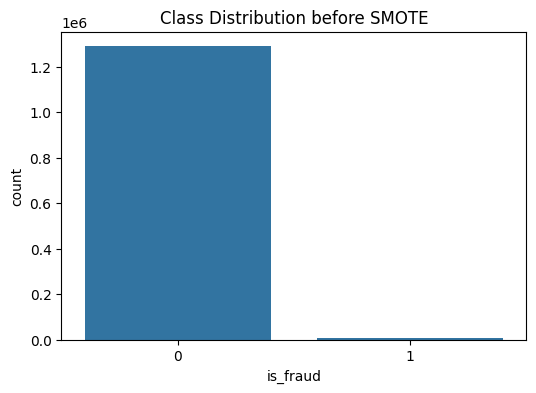

In [19]:
plt.figure(figsize=(6,4))
sns.countplot(x='is_fraud',data=credit_card_data)
plt.title('Class Distribution before SMOTE')
plt.show()

In [10]:
smote = SMOTE(random_state=42)
x_resample, y_resample = smote.fit_resample(x,y)

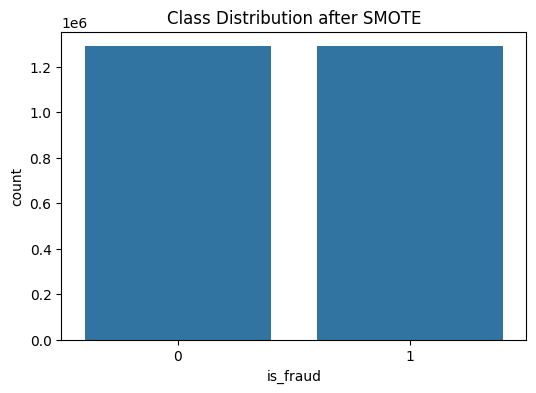

In [20]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resample)
plt.title('Class Distribution after SMOTE')
plt.show()

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_resample,y_resample,test_size=0.2, random_state=42)

In [15]:
lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    metrics='auc',
    is_unbalence = True,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    n_estimators=200
)
lgb_model.fit(x_train,y_train)

[LightGBM] [Warning] Unknown parameter: is_unbalence
[LightGBM] [Warning] Unknown parameter: is_unbalence
[LightGBM] [Info] Number of positive: 1030687, number of negative: 1031983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 2062670, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499686 -> initscore=-0.001257
[LightGBM] [Info] Start training from score -0.001257


LGBMClassifier(is_unbalence=True, learning_rate=0.05, metrics='auc',
               n_estimators=200, objective='binary')

In [16]:
y_pred = lgb_model.predict(x_test)

[LightGBM] [Warning] Unknown parameter: is_unbalence


In [17]:
print("Classification_report:\n", classification_report(y_test,y_pred))
print("Roc AUC Score: ",roc_auc_score(y_test,y_pred))

Classification_report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95    257186
           1       0.97      0.92      0.94    258482

    accuracy                           0.94    515668
   macro avg       0.95      0.94      0.94    515668
weighted avg       0.95      0.94      0.94    515668

Roc AUC Score:  0.9445451231966608


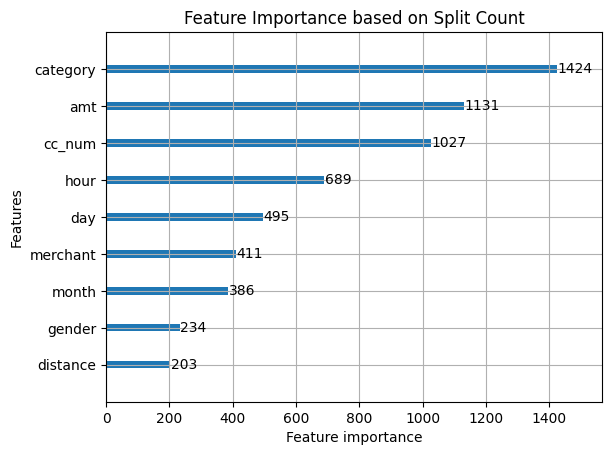

In [21]:
lgb.plot_importance(lgb_model, importance_type='split', max_num_features=10)
plt.title('Feature Importance based on Split Count')
plt.show()

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, lgb_model.predict_proba(x_test)[:,1])
roc_auc = auc(fpr, tpr)

[LightGBM] [Warning] Unknown parameter: is_unbalence


Text(0.5, 1.0, 'ROC')

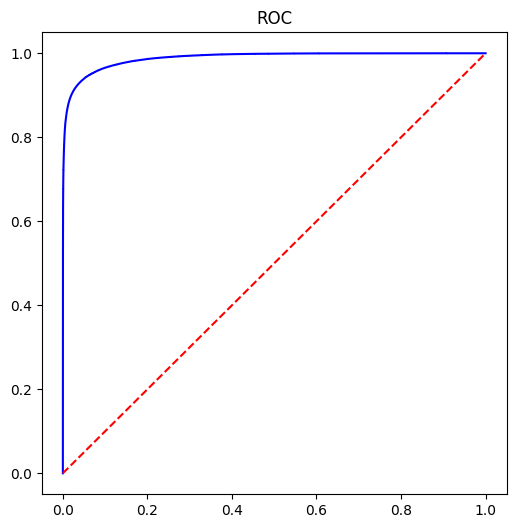

In [23]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('ROC') 

In [18]:
joblib.dump(lgb_model,"fraud_detection_model.jb")
joblib.dump(encoders,"label_encoders.jb")

['label_encoders.jb']